In [38]:
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob, re
from sklearn.model_selection import train_test_split

C:\Users\niraj\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [111]:
#Import the images
import os
os.chdir("C:\\Users\\niraj\\Kate_1\\DatabaseImages\\Images") #Directory with all images created

images=glob.glob("*.png")
label =[] #To keep track of labels of each image
hash_table = {} #To keep tracks of image with respect to name
for i in range(len(images)):
    ints = re.findall(r'\d+', images[i])
    hash_table[i] = [int(x) for x in ints]
    label.append( hash_table[i][0])


data =[]

for image in images:
    data.append(np.asarray(Image.open(image).convert('L')))


[Train, Test,Train_Labels, Test_Labels] = train_test_split(data, label, test_size=0.2) #This splits the dataset into training and validating with the size provided.

image_size = Train[0].shape[1]
Train = np.reshape(Train, (-1, image_size, image_size, 1))
Test = np.reshape(Test, (-1, image_size, image_size, 1))

#Normalisation
Train = Train.astype('float32') / 255
Test = Test.astype('float32') / 255


# Generate corrupted images by adding noise with normal dist
# centered at 0.5 and std=0.5
noise = np.random.normal(loc=0.5, scale=0.5, size=Train.shape)
Train_noisy = Train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=Test.shape)
Test_noisy = Test + noise

Train_noisy = np.clip(Train_noisy, 0., 1.)
Test_noisy = np.clip(Test_noisy, 0., 1.)



In [108]:
def encoder(input_img): #Define parameters of Encoder and Decoder structure. 
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    return conv3

def decoder(conv3):
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

input_img = Input(shape = (100, 100, 1))
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mse', optimizer = 'adam')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 100, 100, 32)      320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 25, 25, 128)       73856     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 25, 25, 128)       147584    
__________

In [113]:
autoencoder_train = autoencoder.fit(Train_noisy, Train, batch_size=68,epochs=20,verbose=1,validation_data=(Test_noisy, Test))

Train on 1510 samples, validate on 378 samples
Epoch 1/20
1510/1510 [==============================] - 116s 77ms/step - loss: 0.0323 - val_loss: 0.0204
Epoch 2/20
1510/1510 [==============================] - 118s 78ms/step - loss: 0.0170 - val_loss: 0.0145
Epoch 3/20
1510/1510 [==============================] - 133s 88ms/step - loss: 0.0103 - val_loss: 0.0071
Epoch 4/20
1510/1510 [==============================] - 135s 89ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 5/20
1510/1510 [==============================] - 133s 88ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 6/20
1510/1510 [==============================] - 132s 88ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 7/20
1510/1510 [==============================] - 132s 87ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 8/20
1510/1510 [==============================] - 138s 91ms/step - loss: 0.0042 - val_loss: 0.0049
Epoch 9/20
1510/1510 [==============================] - 136s 90ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 10

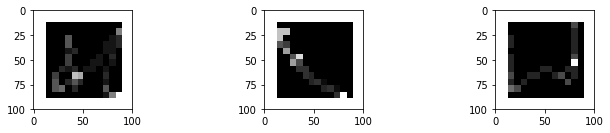

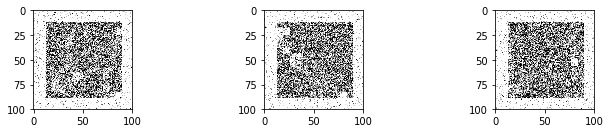

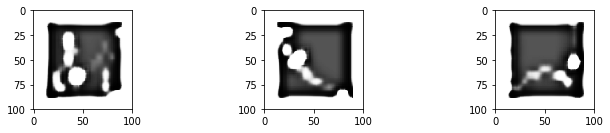

In [114]:
Decoded = autoencoder.predict(Test) #Predict output of decoder to see what the network has learnt

plt.figure(figsize=(20, 4))
for i in range(3):
    plt.subplot(2, 5, i+1)
    plt.imshow(Test[i].reshape(100,100), cmap = 'gray')
plt.show()

plt.figure(figsize=(20, 4))
for i in range(3):
    plt.subplot(2, 5, i+1)
    plt.imshow(Test_noisy[i].reshape(100,100), cmap = 'gray')
plt.show()

plt.figure(figsize=(20, 4))
for i in range(3):
    plt.subplot(2, 5, i+1)
    plt.imshow(255*Decoded[i].reshape(100,100), cmap='gray')  
plt.show()

autoencoder.save_weights('autoencoder.h5')


# Add a classifier to the trained Encoder

In [115]:
#Now using the trained autoencoder, we want to replace the decoder part with a classifier
#which will be trained on how to classify the image according to the player.
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(256, activation='relu')(flat)
    out = Dense(len(to_categorical(Train_Labels)[1]), activation='softmax')(den) #Use softmax to get an output which sums to 1, the output being probability of belonging to a class. 
    return out

encode = encoder(input_img) 
full_model = Model(input_img,fc(encode)) #Create full model
for l1,l2 in zip(full_model.layers[:5],autoencoder.layers[0:5]):
    l1.set_weights(l2.get_weights())
    
for layer in full_model.layers[0:5]: #This to prevent the encoder being modified during classification
    layer.trainable = False
    
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
full_model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 100, 100, 32)      320       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 25, 25, 128)       73856     
_________________________________________________________________
flatten_4 (Flatten)          (None, 80000)             0         
__________

In [116]:
classify_train = full_model.fit(Train, to_categorical(Train_Labels), batch_size=128,epochs=100,verbose=1,validation_data=(Test, to_categorical(Test_Labels)))


Train on 1510 samples, validate on 378 samples
Epoch 1/100
1510/1510 [==============================] - 14s 9ms/step - loss: 3.7612 - acc: 0.1026 - val_loss: 2.4689 - val_acc: 0.1058
Epoch 2/100
1510/1510 [==============================] - 15s 10ms/step - loss: 2.4716 - acc: 0.1007 - val_loss: 2.4661 - val_acc: 0.1058
Epoch 3/100
1510/1510 [==============================] - 15s 10ms/step - loss: 2.4471 - acc: 0.1007 - val_loss: 2.4071 - val_acc: 0.1058
Epoch 4/100
1510/1510 [==============================] - 15s 10ms/step - loss: 2.3655 - acc: 0.1232 - val_loss: 2.3384 - val_acc: 0.1534
Epoch 5/100
1510/1510 [==============================] - 17s 11ms/step - loss: 2.3131 - acc: 0.1669 - val_loss: 2.3080 - val_acc: 0.1534
Epoch 6/100
1510/1510 [==============================] - 17s 11ms/step - loss: 2.2836 - acc: 0.1861 - val_loss: 2.2839 - val_acc: 0.2037
Epoch 7/100
1510/1510 [==============================] - 18s 12ms/step - loss: 2.2350 - acc: 0.2007 - val_loss: 2.2689 - val_acc: 0.

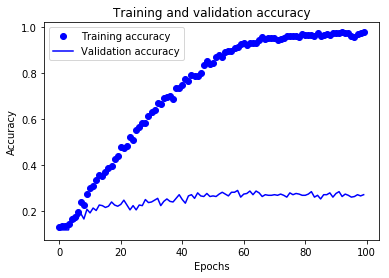

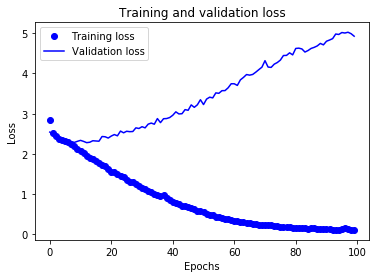

In [95]:
#Plot Accuracy and Loss of learning


accuracy = classify_train.history['acc']
val_accuracy = classify_train.history['val_acc']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()